In [106]:
# importing general necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
# data preparation libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
# models that are fitted on the data
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

In [107]:
# importing the dataset and making some adjustments so it works with the model and the time series split
df = pd.read_csv("../data/combined_dataset_temp.csv").drop(columns=["Unnamed: 0", "GAUL", "M49"])
df["Casualties"] = df["Casualties"].fillna(0)
df["Undernourishment (%)"] = df["Undernourishment (%)"].replace({"<2.5": 0})
df["Undernourishment (%)"] = pd.to_numeric(df["Undernourishment (%)"]).shift(periods=-1)
df = df.drop(index=df.index[19::20])
df = df.dropna().sort_values("Year")

In [108]:
# Creating training and test data, but not randomly splitting (roughly two years get excluded) and scaling
sc_x = StandardScaler()
sc_y = StandardScaler()

df_model = df.drop(columns=["Area", "Year", "GDP (MUSD)", "Food Prod. Index"])

df_model_x = sc_x.fit_transform(df_model[["GNI (MUSD)", "Temperature", "Precipitation", "NDVI", "Casualties"]])
df_model_x = pd.DataFrame(df_model_x, columns=["GNI (MUSD)", "Temperature", "Precipitation", "NDVI", "Casualties"])

df_model_y = sc_y.fit_transform(df_model["Undernourishment (%)"].array.reshape(-1, 1))
df_model_y = pd.DataFrame(df_model_y, columns=["Undernourishment (%)"])

y_train = df_model_y["Undernourishment (%)"].iloc[:-310]
X_train = df_model_x.iloc[:-310]

y_test = df_model_y["Undernourishment (%)"].iloc[-310:]
X_test = df_model_x.iloc[-310:]

In [109]:
# testing different models
dict_regressors = {
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "Linear SVM": SVR(),
    "Nearest Neighbors": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Neural Network": MLPRegressor(max_iter=1000)
}

tscv = TimeSeriesSplit(n_splits=5, test_size=310)

model_list = ["Random Forest",
    "Gradient Boosting",
    "Linear SVM",
    "Nearest Neighbors",
    "Decision Tree",
    "Linear Regression",
    "Ridge Regression",
    "Neural Network"]
model_score = []
model_score_std = []

for regressor_name, regressor_value in dict_regressors.items():

    model = regressor_value
    scores = cross_val_score(model, X_train, y_train, cv=tscv)

    model_score.append(scores.mean())
    model_score_std.append(scores.std())

    print(str(regressor_name) + ": %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Random Forest: 0.78 accuracy with a standard deviation of 0.02
Gradient Boosting Regressor: 0.64 accuracy with a standard deviation of 0.01
Linear SVM: 0.40 accuracy with a standard deviation of 0.03
Nearest Neighbors: 0.58 accuracy with a standard deviation of 0.07
Decision Tree: 0.56 accuracy with a standard deviation of 0.11
Linear Regression: 0.16 accuracy with a standard deviation of 0.04
Ridge Regression: 0.16 accuracy with a standard deviation of 0.04
Neural Network: 0.53 accuracy with a standard deviation of 0.03


In [110]:
model_comparison = pd.DataFrame(
    {'Model': model_list,
     'Average Score': model_score,
     'Standard diviation': model_score_std
    })
model_comparison.to_csv('../data/model_comparison.csv')

In [111]:
print(model_score, model_score_std)
print(model_list)

model_comparison = pd.DataFrame(
    {'Model': model_list,
     'Average Score': model_score,
     'Standard diviation': model_score_std
    })
model_comparison.to_csv('../data/model_comparison.csv')
print(model_comparison)

[0.7822088978137665, 0.638269341411136, 0.4002486983029212, 0.5806491871499923, 0.5578597460547192, 0.1565161734969317, 0.15671640012683954, 0.5294125451442009] [0.016707303965924132, 0.014079878325713835, 0.025876575053713984, 0.07299081059447919, 0.11330460468203198, 0.040098706147436346, 0.03999587767985208, 0.03456756134039352]
['Random Forest', 'Gradient Boosting', 'Linear SVM', 'Nearest Neighbors', 'Decision Tree', 'Linear Regression', 'Ridge Regression', 'Neural Network']
               Model  Average Score  Standard diviation
0      Random Forest       0.782209            0.016707
1  Gradient Boosting       0.638269            0.014080
2         Linear SVM       0.400249            0.025877
3  Nearest Neighbors       0.580649            0.072991
4      Decision Tree       0.557860            0.113305
5  Linear Regression       0.156516            0.040099
6   Ridge Regression       0.156716            0.039996
7     Neural Network       0.529413            0.034568


In [112]:
# Compare with normal split, to see how much trend there actually is in the data
model = RandomForestRegressor()
scores = cross_val_score(model, X_train, y_train, cv=5)

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.81 accuracy with a standard deviation of 0.04


In [113]:
# using the best model to predict the test data, after fitting it on the training data
model = RandomForestRegressor()
model.fit(X_train, y_train)

print("model score on training data:",model.score(X_train, y_train))
print("model score on test data:",model.score(X_test, y_test))

model score on training data: 0.9826233352727872
model score on test data: 0.769958593606775


In [114]:
# making predictions and saving the results
res = pd.DataFrame()
res["Pred. Undernourishment"] = model.predict(X_test)
res = sc_y.inverse_transform(res)

df_result = df[["Area", "Year", "Undernourishment (%)"]].iloc[-310:]
df_result["Pred. Undernourishment"] = res
df_result = df_result.sort_values("Area").rename(columns={"Undernourishment (%)": "Real Undernourishment"})
df_result.to_csv("../data/future_pred_result.csv")

TypeError: 'str' object is not callable

<Figure size 432x288 with 0 Axes>

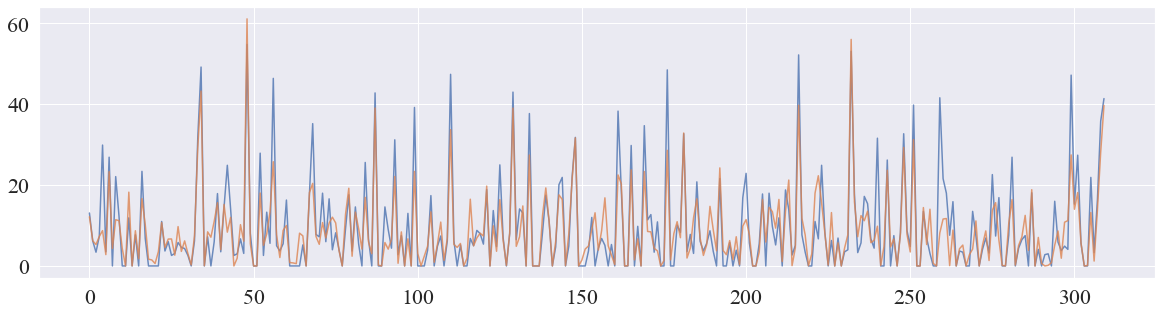

In [159]:
# plotting actual vs predicted undernourishment
plt.figure()
plt.figure(figsize=(20, 5))
plt.plot(df_model["Undernourishment (%)"].iloc[-310:].to_numpy(), alpha=0.8, label="observed undernourishment")
plt.plot(res,alpha=0.8, label="predicted undernourishment")
plt.xlabel("sample number")
plt.ylabel("undernourishment (%)")
plt.legend(loc="upper left")
plt.xlim(0,100)
plt.ylim(0,50)
plt.grid()
plt.show()

[Text(0, 0, '0.782209'),
 Text(0, 0, '0.638269'),
 Text(0, 0, '0.580649'),
 Text(0, 0, '0.55786'),
 Text(0, 0, '0.529413'),
 Text(0, 0, '0.400249'),
 Text(0, 0, '0.156716'),
 Text(0, 0, '0.156516')]

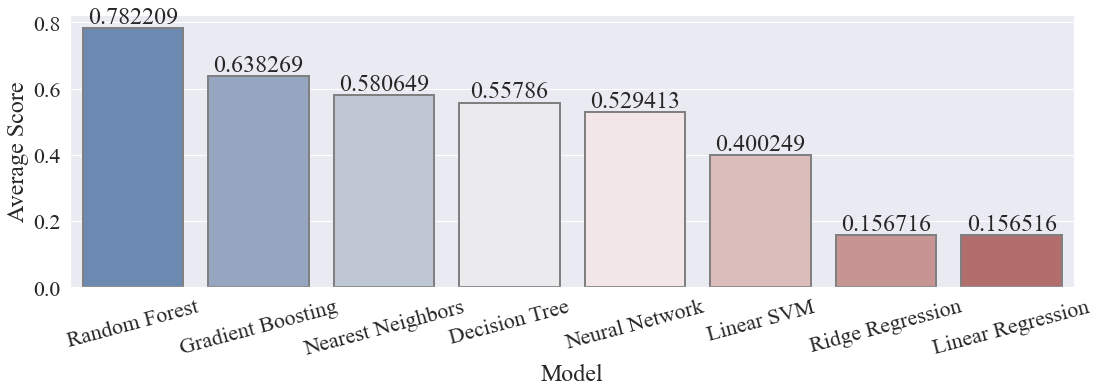

In [160]:
import seaborn as sns

model_comparison = model_comparison.sort_values(['Average Score'], ascending=False)

sns.set_theme(style="darkgrid", font='Times New Roman', font_scale=2)
plt.figure(figsize=(18, 5))
ax = sns.barplot(data = model_comparison, x="Model", y="Average Score", palette="vlag", capsize=.9,
linewidth=2, edgecolor="0.5")

for item in ax.get_xticklabels():
    item.set_rotation(15)

ax.bar_label(ax.containers[0])
